# Solutions-02

### Setup Code

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set() # for plot formatting

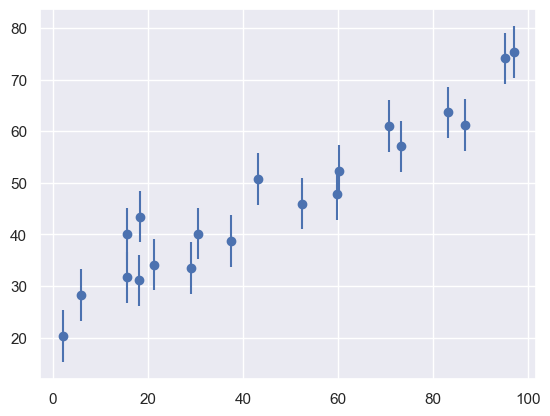

In [2]:
# Making the data

def make_data(intercept, slope, N=20, dy=5, rseed=42):
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(N)
    y = intercept + slope * x
    y += dy * rand.randn(N)
    return x, y, dy * np.ones_like(x)

theta_true = [25, 0.5]
x, y, dy = make_data(*theta_true)
plt.errorbar(x, y, dy, fmt='o');

### Quick Exercise

1. Write a Python function which computes the log-likelihood given a parameter vector $\theta$, an array of errors $\varepsilon$, and an array of $x$ and $y$ values

2. Use tools in [``scipy.optimize``](http://docs.scipy.org/doc/scipy/reference/optimize.html) to maximize this likelihood (i.e. minimize the negative log-likelihood). How close is this result to the input ``theta_true`` above?

#### Solution

In [3]:
def log_likelihood(theta, x, y, dy):
    y_model = theta[0] + theta[1] * x
    return -0.5 * np.sum(np.log(2 * np.pi * dy ** 2) +
                         (y - y_model) ** 2 / dy ** 2)

In [4]:
from scipy import optimize

def minfunc(theta, x, y, dy):
    return -log_likelihood(theta, x, y, dy)

result = optimize.minimize(minfunc, x0=[0, 0], args=(x, y, dy))
print("result:", result.x)
print("input", theta_true)

result: [24.81802606  0.47417325]
input [25, 0.5]


### Breakout

1. Using matplotlib, plot the posterior probability distribution for the slope and intercept, once for each prior. I would suggest using ``plt.contourf()`` or ``plt.pcolor()``. How different are the distributions?

2. Modify the dataset – how do the results change if you have very few data points or very large errors?

3. If you finish this quickly, try adding 1-sigma and 2-sigma contours to your plot, keeping in mind that the probabilities are not normalized! You can add them to your plot with ``plt.contour()``.

#### Setup

These are the two prior functions we defined in the notebook:

In [5]:
def log_flat_prior(theta):
    if np.all(np.abs(theta) < 1000):
        return 0
    else:
        return -np.inf  # log(0)
    
def log_symmetric_prior(theta):
    if np.abs(theta[0]) < 1000:
        return -1.5 * np.log(1 + theta[1] ** 2)
    else:
        return -np.inf  # log(0)

#### Solution

We'll start by defining a function which takes a two-dimensional grid of likelihoods and returns 1, 2, and 3-sigma contours.
This acts by sorting and normalizing the values and then finding the locations of the $0.68^2$, $0.95^2$, and $0.997^2$ cutoffs:

In [6]:
def contour_levels(grid):
    """Compute 1, 2, 3-sigma contour levels for a gridded 2D posterior"""
    sorted_ = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(sorted_) / np.sum(sorted_)
    cutoffs = np.searchsorted(pct, np.array([0.68, 0.95, 0.997]) ** 2)
    return sorted_[cutoffs]

Now we define a function to compute and plot the results of the Bayesian analysis:

In [7]:
def plot_results(x, y, dy,
                 slope_limits=(0.3, 0.7),
                 intercept_limits=(15, 35)):
    # 1. Evaluate the log probability on the grid (once for each prior)
    slope_range = np.linspace(*slope_limits)
    intercept_range = np.linspace(*intercept_limits)

    log_P1 = [[log_likelihood([b, m], x, y, dy) + log_flat_prior([b, m])
               for m in slope_range] for b in intercept_range]
    log_P2 = [[log_likelihood([b, m], x, y, dy) + log_symmetric_prior([b, m])
               for m in slope_range] for b in intercept_range]

    # For convenience, we normalize the probability density such that the maximum is 1
    P1 = np.exp(log_P1 - np.max(log_P1))
    P2 = np.exp(log_P2 - np.max(log_P2))

    # 2. Create two subplots and plot contours showing the results
    fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                           sharex=True, sharey=True)
    
    ax[0].contourf(slope_range, intercept_range, P1, 100, cmap='Blues')
    ax[0].contour(slope_range, intercept_range, P1, contour_levels(P1), colors='black')
    ax[0].set_title('Flat Prior')

    ax[1].contourf(slope_range, intercept_range, P2, 100, cmap='Blues')
    ax[1].contour(slope_range, intercept_range, P2, contour_levels(P1), colors='black')
    ax[1].set_title('Symmetric Prior')

    # 3. Add grids and set axis labels
    for axi in ax:
        axi.grid('on', linestyle=':', color='gray', alpha=0.5)
        axi.set_axisbelow(False)
        axi.set_xlabel('slope')
        axi.set_ylabel('intercept')

ValueError: Contour levels must be increasing

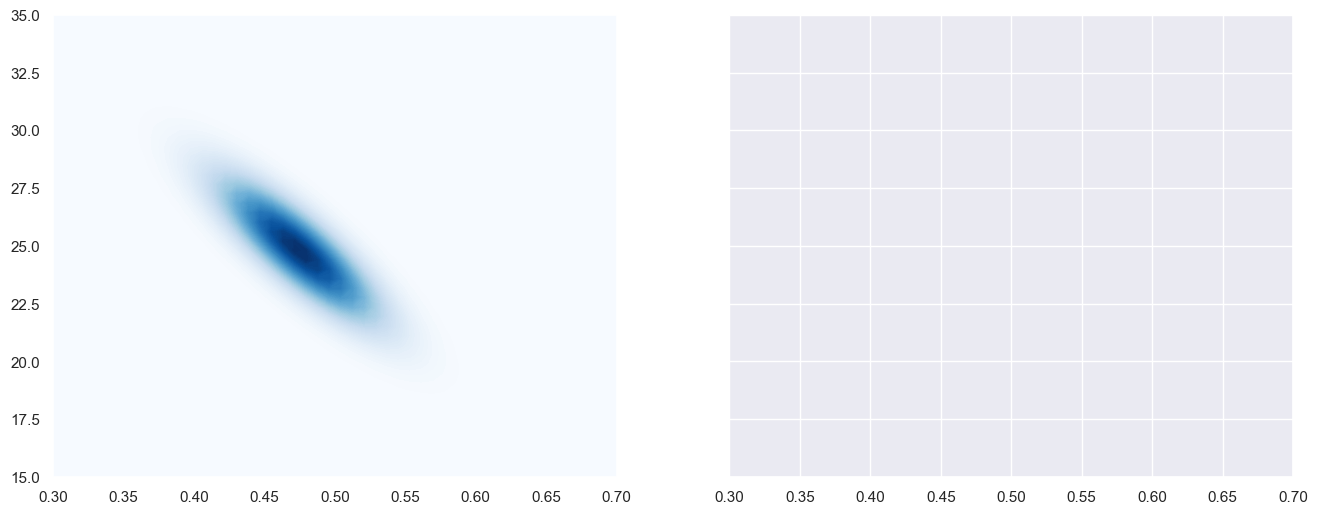

In [8]:
plot_results(x, y, dy)

We see that the form of the prior in this case makes very little difference to the final posterior. In general, this often ends up being the case: for all the worrying about the effect of the prior, when you have enough data to constrain your model well, the prior has very little effect.

Let's use some different data and see what happens:

In [ ]:
x2, y2, dy2 = make_data(*theta_true, N=3, dy=40)
plt.errorbar(x2, y2, dy2, fmt='o');

In [ ]:
plot_results(x2, y2, dy2,
             slope_limits=(-2, 5),
             intercept_limits=(-300, 200))

We see here that the form of the prior **does** have a clear effect in the case where the data don't constrain the model well (in this case, three points with very large error bars).
This encodes exactly what you would scientifically expect: if you don't have very good data, it is unlikely to change your views of the world (which are of course encoded in the prior).